In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# helper function to plot curves
def make_plot(metric_values, train_values, cv_values, model_name, metric_name, score_name, curve_type):
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(metric_values, train_values, label='Training score')
    ax.plot(metric_values, cv_values, label='CV score')
    ax.set_xlabel(metric_name)
    ax.set_ylabel(score_name)
    title = '{} curve for {} ({})'.format(curve_type, model_name, score_name)
    ax.set_title(title)
    ax.legend()
    
def plot_curve(model, model_name, X, y, param_name, scoring, curve_type, param_range=None):
    
    if curve_type == 'Validation':
        train_scores, cv_scores = validation_curve(model, X, y,
                                                   param_name=param_name, 
                                                   param_range=param_range, 
                                                   scoring=scoring,
                                                   cv=5,
                                                   n_jobs=-1)
    elif curve_type == 'Learning':
        train_sizes, train_scores, cv_scores = learning_curve(model, X, y,
                                                              train_sizes=np.linspace(.1, 1.0, 100),
                                                              scoring=scoring,
                                                              cv=5,
                                                              n_jobs=-1)
        param_range = train_sizes
        
    train_score_means = np.mean(train_scores, axis=1)
    cv_score_means = np.mean(cv_scores, axis=1)
    
    make_plot(metric_values=param_range,
              train_values=train_score_means,
              cv_values = cv_score_means,
              model_name=model_name, 
              metric_name=param_name.capitalize().replace('_',' '),
              score_name=scoring.capitalize(),
              curve_type=curve_type
             )

## Red & White Wine Dataset

In [3]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red = pd.read_csv('winequality-red.csv', sep=';')

df_white['type'] = ['white'] * len(df_white)
df_red['type'] = ['red'] * len(df_red)

df = pd.concat([df_white, df_red])

X = df.drop(['quality', 'type'], axis=1) 
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# In data_exploration we see almost all features have a normal distribution 
# So it makes sense to use StandardScaler
scaler = StandardScaler()
encoder = LabelEncoder() 

# Apply the scaler on train and test data separately
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
y_train = encoder.fit_transform(y_train)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 
y_test = encoder.fit_transform(y_test)

**Train a basic classifier with default parameters.**

In [4]:
clf = GradientBoostingClassifier(random_state=2020)

**Look at how tree depth affects classifier accuracy. Max tree depth is the number of features.**

CPU times: user 131 ms, sys: 64.8 ms, total: 196 ms
Wall time: 26.3 s


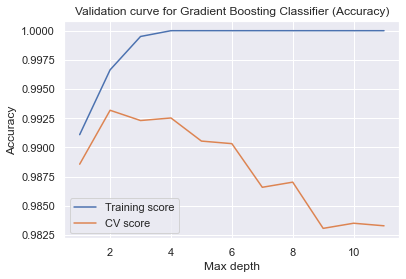

In [5]:
%%time
depth_values = list(range(1,len(X.columns) + 1))
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_depth', 
           param_range=depth_values, 
           scoring='accuracy', 
           curve_type='Validation')

**Now look at the number of estimators.**

CPU times: user 623 ms, sys: 69.6 ms, total: 692 ms
Wall time: 59.9 s


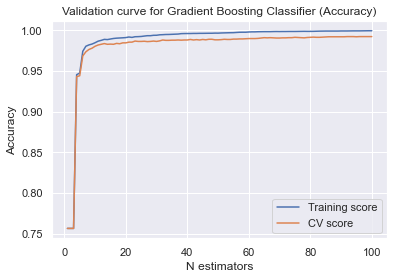

In [6]:
%%time
num_learners = list(range(1,101))
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='n_estimators',
           param_range=num_learners, 
           scoring='accuracy', 
           curve_type='Validation')

**Refine the range.**

CPU times: user 228 ms, sys: 23.7 ms, total: 251 ms
Wall time: 8.28 s


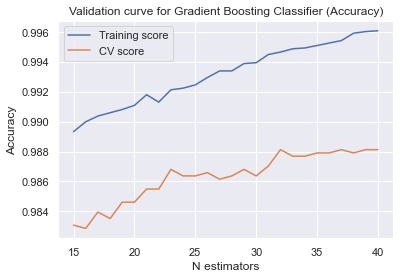

In [7]:
%%time
num_learners = list(range(15,41))
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='n_estimators',
           param_range=num_learners, 
           scoring='accuracy', 
           curve_type='Validation')

**Now look at the learning rate.**

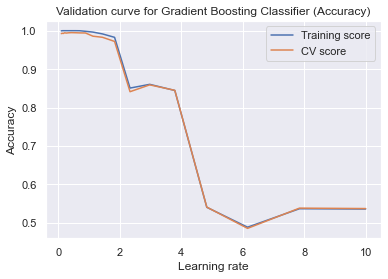

In [8]:
learning_rate_range = np.logspace(-1, 1, 20)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='accuracy', 
           curve_type='Validation')

**Refine range.**

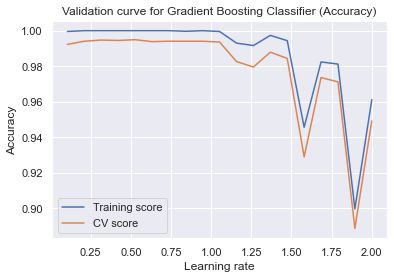

In [9]:
learning_rate_range = np.linspace(0, 2, 20)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='accuracy', 
           curve_type='Validation')

**And again.**

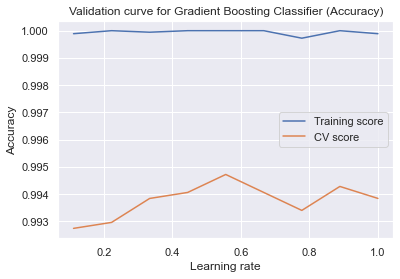

In [10]:
learning_rate_range = np.linspace(0, 1, 10)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='accuracy', 
           curve_type='Validation')

**Perform grid search.**

In [11]:
%%time
search_parameters = {'max_depth':list(range(1,5)),
                     'n_estimators': list(range(40,55)),
                     'learning_rate': np.linspace(.4,.6,10)
                    }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'learning_rate': 0.5333333333333333, 'max_depth': 3, 'n_estimators': 46}
CPU times: user 5.46 s, sys: 582 ms, total: 6.05 s
Wall time: 4min 39s


**Train the model with best parameters.**

In [12]:
%%time
clf = GradientBoostingClassifier(n_estimators=46,
                                 max_depth=3, 
                                 learning_rate=0.5333333333333333,
                                 random_state=2020
                                )
clf.fit(X_train, y_train)

CPU times: user 300 ms, sys: 4.58 ms, total: 305 ms
Wall time: 312 ms


GradientBoostingClassifier(learning_rate=0.5333333333333333, n_estimators=46,
                           random_state=2020)

CPU times: user 558 ms, sys: 63.6 ms, total: 621 ms
Wall time: 34.5 s


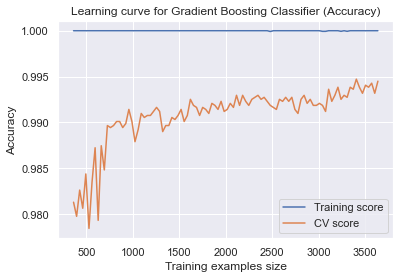

In [13]:
%%time
# Look at the learning rate
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='accuracy', 
           curve_type='Learning')

In [14]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 4.45 ms, sys: 1.32 ms, total: 5.77 ms
Wall time: 6.56 ms


In [15]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9979    0.9796    0.9887       491
           1     0.9932    0.9993    0.9962      1459

    accuracy                         0.9944      1950
   macro avg     0.9956    0.9895    0.9925      1950
weighted avg     0.9944    0.9944    0.9943      1950



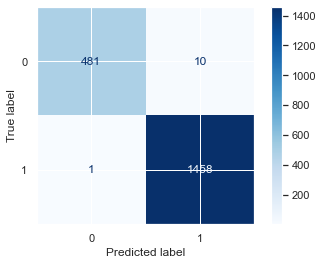

In [16]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);

## Shill Bidding Dataset

In [17]:
df = pd.read_csv("Shill Bidding Dataset.csv")

X = df.drop(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# Use MinMaxScaler because data has outliers, and we want to highlight those
scaler = MinMaxScaler() 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 

**Train a basic classifier with default parameters.**

In [18]:
clf = GradientBoostingClassifier(random_state=2020)

**Look at how tree depth affects classifier accuracy. Max tree depth is the number of features.**

CPU times: user 121 ms, sys: 14.4 ms, total: 135 ms
Wall time: 14.6 s


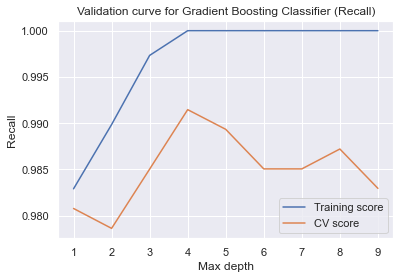

In [19]:
%%time
depth_values = np.arange(1,len(X.columns) + 1)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_depth', 
           param_range=depth_values, 
           scoring='recall', 
           curve_type='Validation')

**Now look at the number of estimators.**

CPU times: user 759 ms, sys: 172 ms, total: 931 ms
Wall time: 56.2 s


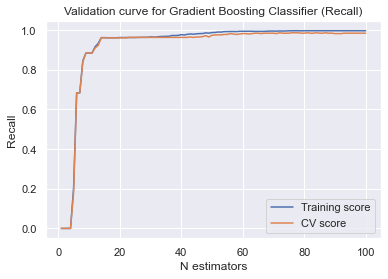

In [20]:
%%time
num_learners = list(range(1,101))
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='n_estimators',
           param_range=num_learners, 
           scoring='recall', 
           curve_type='Validation')

**Refine the range.**

CPU times: user 267 ms, sys: 28 ms, total: 295 ms
Wall time: 17.9 s


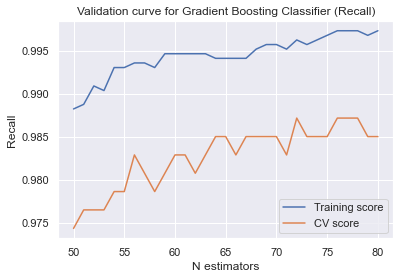

In [21]:
%%time
num_learners = list(range(50,81))
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='n_estimators',
           param_range=num_learners, 
           scoring='recall', 
           curve_type='Validation')

**Now look at the learning rate.**

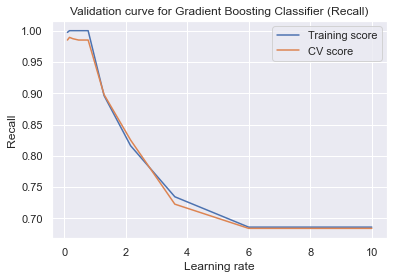

In [22]:
learning_rate_range = np.logspace(-1, 1, 10)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='recall', 
           curve_type='Validation')

**Reduce the range.**

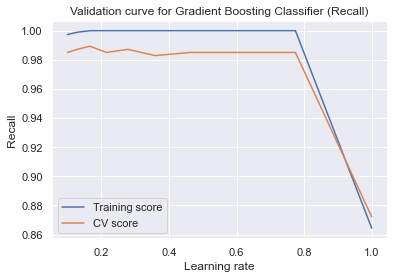

In [23]:
learning_rate_range = np.logspace(-1, 0, 10)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='recall', 
           curve_type='Validation')

**And again.**

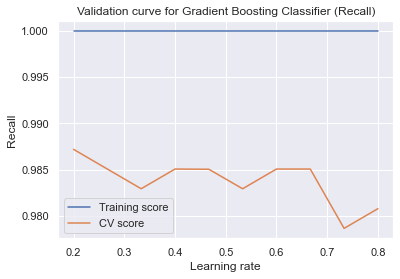

In [24]:
learning_rate_range = np.linspace(0.2, 0.8, 10)
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate', 
           param_range=learning_rate_range,
           scoring='recall', 
           curve_type='Validation')

**Now we can use values from previous graphs to define the range for grid search and run the grid search.**

In [25]:
%%time
search_parameters = {'max_depth':[4,5],
                     'n_estimators': list(range(65,81)),
                     'learning_rate': np.linspace(.4,.7,10)
                    }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='recall', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'learning_rate': 0.43333333333333335, 'max_depth': 4, 'n_estimators': 72}
CPU times: user 3.77 s, sys: 354 ms, total: 4.12 s
Wall time: 5min 22s


**Train the model with grid search parameters.**

In [26]:
%%time
clf = GradientBoostingClassifier(n_estimators=72, 
                                 max_depth=4, 
                                 learning_rate=0.43333333333333335,
                                 random_state=2020
                                )
clf.fit(X_train, y_train)

CPU times: user 455 ms, sys: 2.8 ms, total: 457 ms
Wall time: 458 ms


GradientBoostingClassifier(learning_rate=0.43333333333333335, max_depth=4,
                           n_estimators=72, random_state=2020)

**Look at the learning curve.**

CPU times: user 828 ms, sys: 97.3 ms, total: 925 ms
Wall time: 57 s


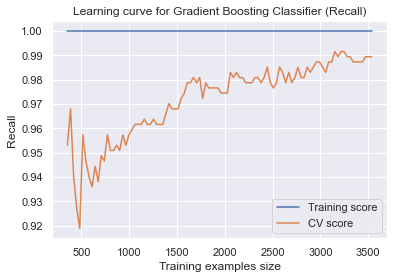

In [27]:
%%time
plot_curve(model=clf,
           model_name='Gradient Boosting Classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='recall', 
           curve_type='Learning')

**Run the model on test data.**

In [28]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 5.45 ms, sys: 1.33 ms, total: 6.78 ms
Wall time: 6.22 ms


In [29]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9994    0.9994      1690
           1     0.9952    0.9952    0.9952       207

    accuracy                         0.9989      1897
   macro avg     0.9973    0.9973    0.9973      1897
weighted avg     0.9989    0.9989    0.9989      1897



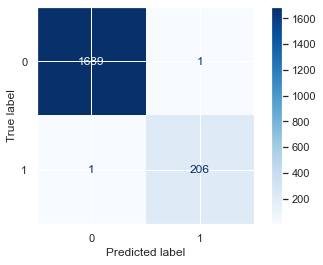

In [30]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);